<a href="https://colab.research.google.com/github/SarveshPatil99/Adversarial-Robustness-Enhancement/blob/main/TML_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
pip install image-classifiers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00


In [1]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip cats_and_dogs_filtered.zip

--2023-11-07 01:11:11--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.207, 108.177.112.207, 74.125.124.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   174MB/s    in 0.4s    

2023-11-07 01:11:12 (174 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

--2023-11-07 01:11:12--  http://cats_and_dogs_filtered.zip/
Resolving cats_and_dogs_filtered.zip (cats_and_dogs_filtered.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘cats_and_dogs_filtered.zip’
FINISHED --2023-11-07 01:11:12--
Total wall clock time: 0.6s
Downloaded: 1 files, 65M in 0.4s (174 MB/s)


In [ ]:
!unzip cats_and_dogs_filtered.zip

In [88]:
import tensorflow as tf
import numpy as np
import pathlib
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
import pickle
from matplotlib import pyplot as plt
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [4]:
dataset_name = 'cats_and_dogs_filtered'
train_dir = pathlib.Path(f'{dataset_name}/train')
val_dir = pathlib.Path(f'{dataset_name}/validation')
train_len = len(list(train_dir.glob('*/*.jpg')))
val_len = len(list(val_dir.glob('*/*.jpg')))
classes = np.array(os.listdir(f'{dataset_name}/train'))
class_dict = dict(zip(classes,range(len(classes))))
print(train_len, val_len)
print(class_dict)

2000 1000
{'dogs': 0, 'cats': 1}


In [5]:
import time
def benchmark(dataset, num_epochs=2, label=''):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(0.01)
    elapsed = time.perf_counter() - start_time
    print(f"{label} Execution time: {elapsed:.4f}")
    return elapsed

In [23]:
img_height = 256
img_width = 256
batch_size = 64

# Helper Functions for tf.data

def create_label(image_path):
  class_name = tf.strings.split(image_path,'/')[-2]
  return tf.cast(classes == class_name,tf.float32)

def load(image_path):

  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image) / 255
  image = tf.image.resize(image, [img_height, img_width])

  label = create_label(image_path)

  return image, label

train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'), shuffle=False)
train_ds = train_ds.shuffle(len(train_ds), reshuffle_each_iteration=False)
train_ds = train_ds.map(load, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.batch(batch_size)
# train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
train_ds_length = len(train_ds)

val_ds = tf.data.Dataset.list_files(str(val_dir/'*/*'), shuffle=False)
val_ds = val_ds.shuffle(len(val_ds), reshuffle_each_iteration=False)
val_ds = val_ds.map(load, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache()
val_ds = val_ds.batch(batch_size)
val_ds_length = len(val_ds)

print(f'train_ds_length: {train_ds_length}, val_ds_length: {val_ds_length}')

train_ds_length: 32, val_ds_length: 16


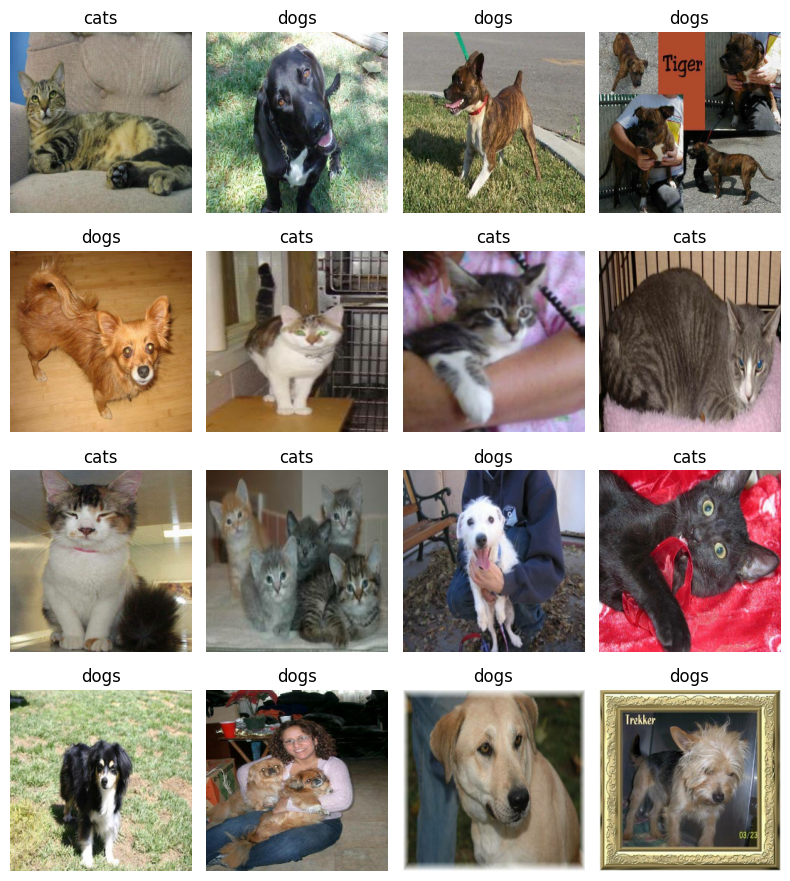

In [46]:
for x, y in train_ds.take(1):
  pass
plt.figure(figsize=(8,9))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(x[i])
  plt.axis('off')
  plt.title(classes[tf.argmax(y[i])])
plt.tight_layout()

In [91]:
def conv_bn_relu(filters,x,idx):
    x = Conv2D(filters, 3, padding='same', kernel_initializer='he_uniform',name=f'conv_{idx}')(x)
    x = BatchNormalization(name=f'bn_{idx}')(x)
    x = ReLU(name=f'relu_{idx}')(x)
    # x = Dropout(rate=0.1,name=f'dropout_{idx}')(x)
    return x

def create_model(input_shape = (256, 256, 3), lr=1e-3):
  input_layer = Input(input_shape,name='input')
  n_filters = 4
  x = input_layer
  for i in range(5):
    x = conv_bn_relu(n_filters,x,i)
    x = MaxPooling2D(name=f'maxpool_{i}')(x)
    n_filters *= 2
  x = Flatten(name='flatten')(x)
  # x = Dense(32,activation='relu',name='dense_0')(x)
  # x = Dropout(rate=0.2,name=f'dropout_dense')(x)
  x = Dense(2,activation='softmax',name='dense_1', dtype = 'float32')(x)

  model = Model(inputs = [input_layer], outputs = [x])

  return model

In [92]:
model = create_model()

In [93]:
lr = 1e-3
epochs = 50
rLR_patience = 5
es_patience = 10
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model_name = 'baseline'
model_filename = f'{model_name}_lr={lr:.0e}'
model_path = f'saved/models/{model_filename}.h5'
history_path = f'saved/histories/{model_filename}.pkl'
pathlib.Path('saved/models').mkdir(exist_ok=True,parents=True)
pathlib.Path('saved/histories').mkdir(exist_ok=True,parents=True)

checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode = 'max', factor=1/np.sqrt(10), patience = rLR_patience, min_lr=1e-6, verbose = 1)
earlystopper = EarlyStopping(monitor='val_accuracy', mode = 'max', patience = es_patience, verbose=1)
callbacks = [checkpoint, reduce_lr, earlystopper]

model = create_model(lr=lr)
optimizer = RMSprop(learning_rate = lr)
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
hist = model.fit(train_ds, epochs = epochs, validation_data = val_ds, callbacks = callbacks, verbose = 2)
with open(history_path, 'wb') as file_pi:
  pickle.dump(hist.history, file_pi)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to saved/models/baseline_lr=1e-03.h5
32/32 - 8s - loss: 1.6140 - accuracy: 0.5565 - val_loss: 3.1853 - val_accuracy: 0.5000 - lr: 0.0010 - 8s/epoch - 256ms/step
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.50000
32/32 - 3s - loss: 1.1838 - accuracy: 0.5480 - val_loss: 1.6544 - val_accuracy: 0.4970 - lr: 0.0010 - 3s/epoch - 88ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.50000 to 0.52400, saving model to saved/models/baseline_lr=1e-03.h5
32/32 - 3s - loss: 0.8830 - accuracy: 0.6170 - val_loss: 0.9029 - val_accuracy: 0.5240 - lr: 0.0010 - 3s/epoch - 81ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.52400 to 0.54200, saving model to saved/models/baseline_lr=1e-03.h5
32/32 - 3s - loss: 0.9625 - accuracy: 0.5930 - val_loss: 0.8826 - val_accuracy: 0.5420 - lr: 0.0010 - 3s/epoch - 82ms/step
Epoch 5/50

Epoch 5: val_accuracy improved from 0.54200 to 0.61100, saving model to saved/mod

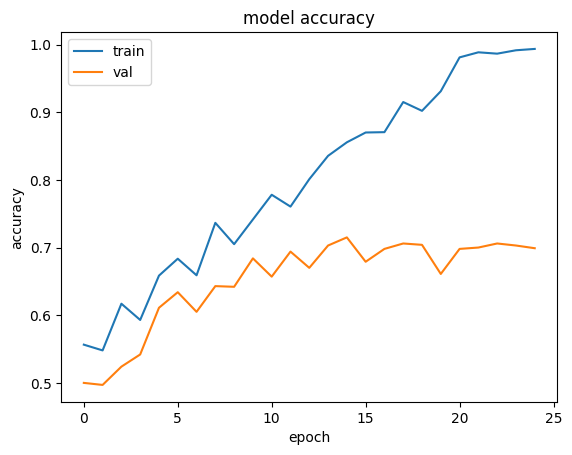

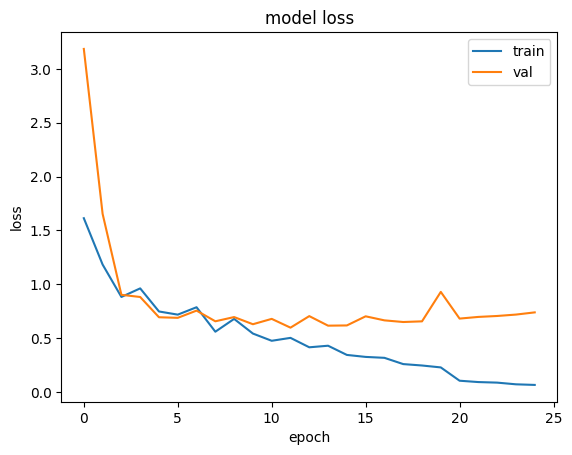

In [101]:
model.load_weights(model_path)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()